# Task 1

### This code is written in google colab to use GPU so the first three cells will work on colab only 

##

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [49]:
ZIP_PATH = "/content/drive/MyDrive/archive.zip"

!mkdir -p /content/mura_data
!unzip -q "/content/drive/MyDrive/archive.zip" -d /content/mura_data

print("unzipped:", os.listdir("/content/mura_data"))


replace /content/mura_data/MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/mura_data/MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: unzipped: ['MURA-v1.1']


In [62]:
print(os.listdir(DATA_ROOT))


['train_labeled_studies.csv', 'train_image_paths.csv', 'train', 'valid_labeled_studies.csv', 'valid', 'valid_image_paths.csv']


In [63]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch # using pyTorch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

using device: cuda


## Segtting up the configuration for the images

In [65]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 3 # this is for faster training
LR = 1e-4

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

## Extracting the data into dataframes

In [66]:
BASE_ROOT = "/content/mura_data"

train_csv_path = os.path.join(BASE_ROOT, "MURA-v1.1/train_image_paths.csv")
valid_csv_path = os.path.join(BASE_ROOT, "MURA-v1.1/valid_image_paths.csv")

print("train_csv_path:", train_csv_path)
print("valid_csv_path:", valid_csv_path)

train_df = pd.read_csv(train_csv_path, header=None, usecols=[0])
valid_df = pd.read_csv(valid_csv_path, header=None, usecols=[0])

train_df.columns = ["rel_path"]
valid_df.columns = ["rel_path"]

#join with BASE_ROOT
train_df["img_path"] = train_df["rel_path"].apply(lambda p: os.path.join(BASE_ROOT, p))
valid_df["img_path"] = valid_df["rel_path"].apply(lambda p: os.path.join(BASE_ROOT, p))



train_csv_path: /content/mura_data/MURA-v1.1/train_image_paths.csv
valid_csv_path: /content/mura_data/MURA-v1.1/valid_image_paths.csv


In [67]:
def get_label(pt):
    pt = pt.lower()
    if "positive" in pt:
        return 1
    if "negative" in pt:
        return 0
    return -1

train_df["label"] = train_df["rel_path"].apply(get_label)
valid_df["label"] = valid_df["rel_path"].apply(get_label)

train_df = train_df[train_df["label"] >= 0].reset_index(drop=True)
valid_df = valid_df[valid_df["label"] >= 0].reset_index(drop=True)

print("train samples:", len(train_df))
print("valid samples:", len(valid_df))


train samples: 36808
valid samples: 3197


## Image prepocessing , transformation

In [68]:
train_tfms = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_tfms = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])


In [69]:
class MDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(row["label"], dtype=torch.float32)


## training loaders

In [70]:
train_ds = MDataset(train_df, transform=train_tfms)
val_ds = MDataset(valid_df, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader)


(1151, 100)

## mobilenet model setup

In [71]:
weights = MobileNet_V2_Weights.IMAGENET1K_V2
model = mobilenet_v2(weights=weights)

in_feats = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_feats, 1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


## training and evaluation batches

In [72]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss/total, total_correct/total


def eval_one_epoch(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1)

            logits = model(imgs)
            loss = criterion(logits, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss/total, total_correct/total


## Model Training

In [74]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for ep in range(1, EPOCHS+1):
    tr_l, tr_a = train_one_epoch(model, train_loader)
    va_l, va_a = eval_one_epoch(model, val_loader)

    train_losses.append(tr_l)
    val_losses.append(va_l)
    train_accs.append(tr_a)
    val_accs.append(va_a)

    print(f"epoch {ep}: train_loss={tr_l:.4f}, train_acc={tr_a:.4f}, val_loss={va_l:.4f}, val_acc={va_a:.4f}")


epoch 1: train_loss=0.4591, train_acc=0.7936, val_loss=0.4530, val_acc=0.7995
epoch 2: train_loss=0.4217, train_acc=0.8158, val_loss=0.4693, val_acc=0.8001
epoch 3: train_loss=0.3988, train_acc=0.8270, val_loss=0.4380, val_acc=0.8079


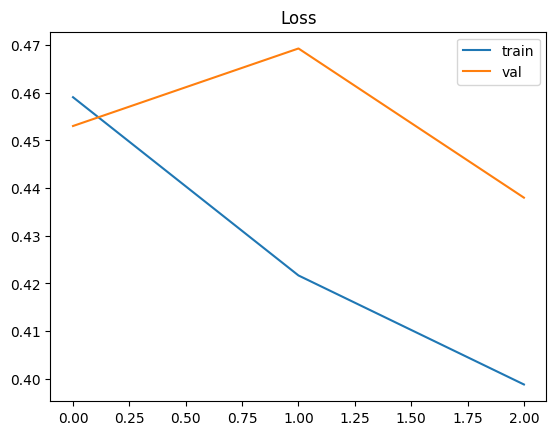

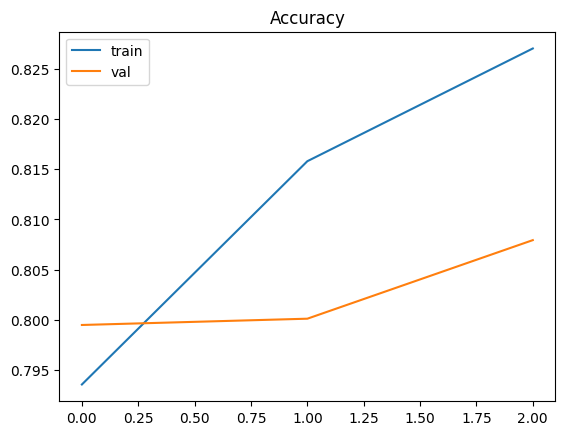

In [75]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.title("Accuracy")
plt.legend()
plt.show()


## Sample predicitions

In [76]:
imgs, labels = next(iter(val_loader))
imgs = imgs.to(device)
labels = labels.to(device).unsqueeze(1)

with torch.no_grad():
    logits = model(imgs)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()

for i in range(5):
    print(f"true={int(labels[i])} pred={int(preds[i])} prob={probs[i].item():.3f}")


true=1 pred=1 prob=0.950
true=1 pred=1 prob=0.863
true=1 pred=1 prob=0.721
true=1 pred=1 prob=0.812
true=1 pred=1 prob=0.969


## Sample Visualization

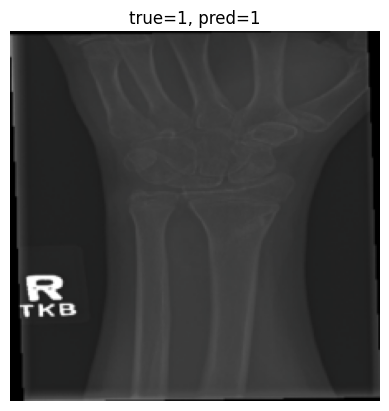

In [77]:
idx = 0

img = imgs[idx].cpu()

mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
std = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
img_vis = img * std + mean
img_vis = img_vis.permute(1, 2, 0).numpy()

plt.imshow(img_vis, cmap="gray")
plt.axis("off")
plt.title(f"true={int(labels[idx])}, pred={int(preds[idx])}")
plt.show()
